In [128]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [129]:
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

def nnse(nse):
    return 1/(2 - nse)

def average(pred_A, pred_B, flow, alpha=0.5):
    flow_pred = alpha * pred_A + (1-alpha) * pred_B
    nse_score = nse(flow, flow_pred)
    return flow_pred, nse_score


def evaluate(pred_A, pred_B, flow, alpha=0.5):

    flow_pred, nse_score = average(pred_A, pred_B, flow, alpha)

    print(f"NSE: {nse_score:.4f}")
    print(f"MSE: {mean_squared_error(flow_pred, flow):.4f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(flow, color='black', label='obs', alpha=1.0)
    ax.plot(flow_pred, color='red', label='pred', alpha=0.7)

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()


In [130]:
pred_lstm_train = np.loadtxt('../results/cotter_lstm_train.txt')
pred_gr4j_train = np.loadtxt('../results/cotter_gr4j_train.txt')
flow_train = np.loadtxt('../results/cotter_train.txt')

In [131]:
pred_gr4j_train = pred_gr4j_train[-len(pred_lstm_train):]
flow_train = flow_train[-len(pred_lstm_train):]

In [132]:
pred_lstm_val = np.loadtxt('../results/cotter_lstm_val.txt')
pred_gr4j_val = np.loadtxt('../results/cotter_gr4j_val.txt')
flow_val = np.loadtxt('../results/cotter_val.txt')

In [133]:
pred_gr4j_val = pred_gr4j_val[-len(pred_lstm_val):]
flow_val = flow_val[-len(pred_lstm_val):]

NSE: 0.6584
MSE: 0.7873


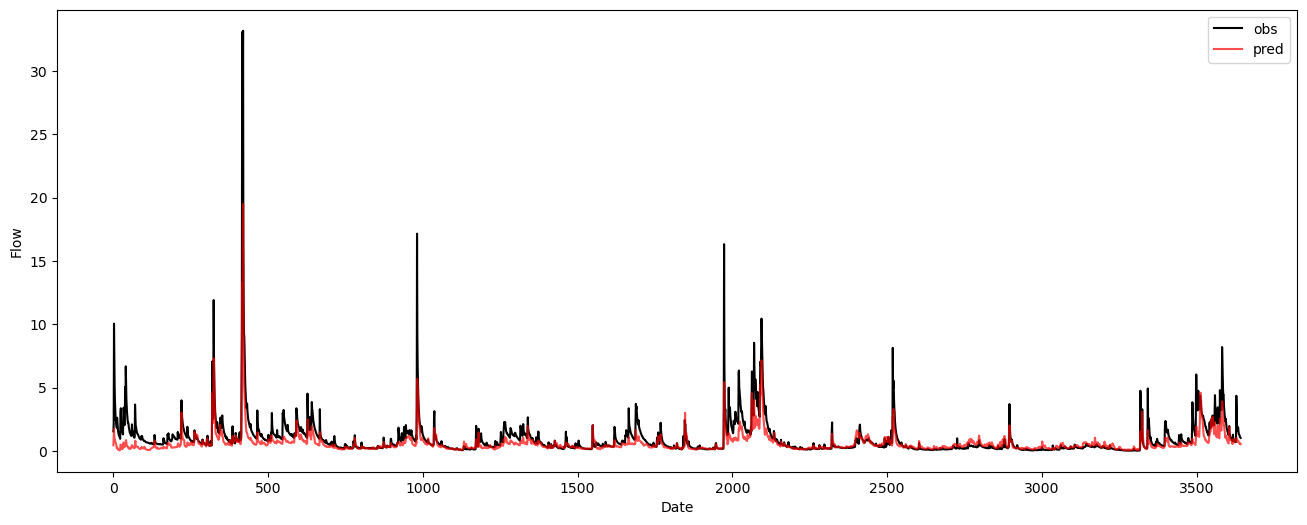

In [142]:
evaluate(pred_lstm_val, pred_gr4j_val, flow_val, alpha=0.50)

In [135]:
from skopt.space import Real
from skopt.utils import use_named_args

space  = [Real(0.1, 0.9, name='alpha')]

@use_named_args(space)
def objective(**params):
    return 1/average(pred_lstm_train, pred_gr4j_train, flow_train, **params)[1]

In [136]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=786)
print(f"Optimized value of alpha: {res_gp.x[0]:.4f}")

Optimized value of alpha: 0.5631


NSE: 0.6535
MSE: 0.7987


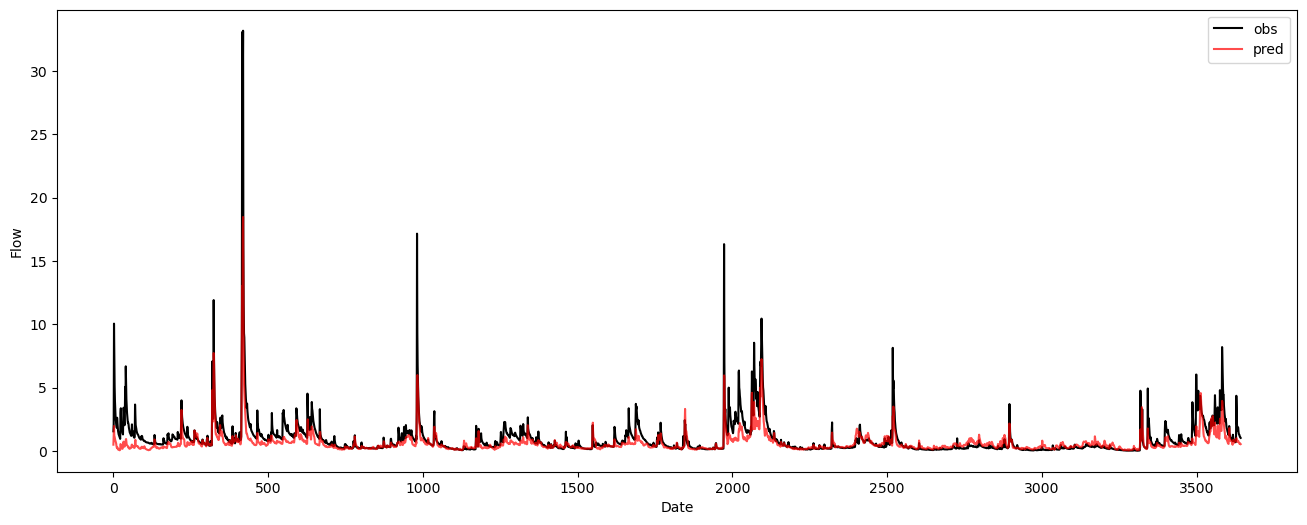

In [137]:
evaluate(pred_lstm_val, pred_gr4j_val, flow_val, alpha=res_gp.x[0])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

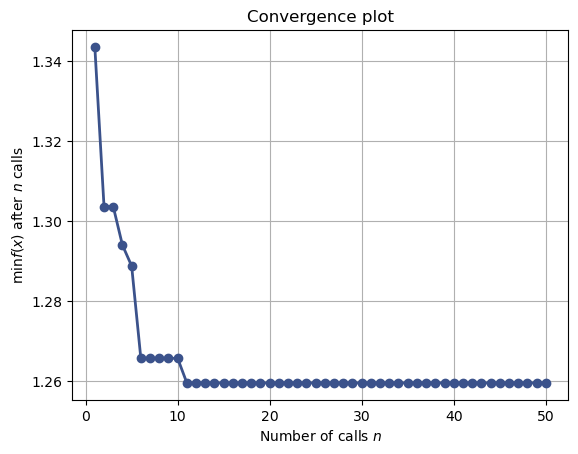

In [141]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)